#### Importing Required Libraries  

- **TensorFlow & Keras**: For building and training neural networks.  
- **Matplotlib**: For data visualization.  
- **NumPy & Pandas**: For numerical operations and data handling.  
- **OS & tqdm**: For file management and progress tracking.  
- **Warnings**: To suppress unnecessary warnings.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#### Load and Preprocess Data  

- Load the **CIFAR-10** dataset and extract training images.  
- Convert images to `float32` for compatibility with TensorFlow.  
- Normalize pixel values to the range **[-1, 1]** for better model performance.  
- Create a **shuffled and batched dataset** using TensorFlow's `tf.data.Dataset`.  
  - **BUFFER_SIZE**: 50,000 (to shuffle all training images).  
  - **BATCH_SIZE**: 128 (for efficient training).  

In [2]:
# Load and preprocess data
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize to [-1, 1]
BUFFER_SIZE = 50000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

170498071/170498071 [==============================] - 11s 0us/step


#### Generator Model  

- The generator is a **deep neural network** that generates images from random noise.  
- It starts with a **dense layer** reshaped into a small 4×4×256 feature map.  
- Uses **Conv2DTranspose layers** to upscale the feature map to **32×32×3** (CIFAR-10 image size).  
- **Batch normalization** and **LeakyReLU activation** help in stable training.  
- The final layer uses a **tanh activation** to scale pixel values to **[-1, 1]**.

In [3]:
# Generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(4 * 4 * 256, use_bias=False, input_dim=100),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((4, 4, 256)),

        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (3, 3), padding='same', use_bias=False, activation='tanh'),
    ])
    return model

generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              409600    
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524288    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

#### Discriminator Model  

- The discriminator is a **CNN-based binary classifier** that distinguishes real images from generated ones.  
- It applies **multiple convolutional layers** with **LeakyReLU activation** to extract features.  
- **Dropout layers** prevent overfitting.  
- The final **dense layer** with **sigmoid activation** outputs a probability score (real vs. fake).  

In [4]:
# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
    layers.Conv2D(64, (3, 3), padding='same', input_shape=[32, 32, 3]),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
    ])
    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)        

#### Loss Functions  

- **Binary Cross-Entropy (BCE)** is used as the loss function for both the generator and discriminator.  

- **Discriminator Loss**:  
  - Measures how well the discriminator differentiates real from fake images.  
  - Computes loss for real images (`real_output`) vs. fake images (`fake_output`).  
  - Encourages the model to assign high scores to real images and low scores to fake images.  

- **Generator Loss**:  
  - Encourages the generator to create realistic images.  
  - Compares generated image scores (`fake_output`) against real labels (1s).  
  - The goal is to fool the discriminator into classifying fake images as real.  

In [5]:
# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [6]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### Generate and Save Images  

- Generates **sample images** from random noise using the generator model.  
- Saves images at different epochs to track training progress.  
- Normalizes pixel values back to **[0, 255]** for visualization.  

In [7]:
# Generate and save images
def generate_and_save_images(model, epoch, test_input, output_path):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(5, 5))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i + 1)
        image = (predictions[i] * 127.5 + 127.5).numpy().astype(np.uint8)
        plt.imshow(image)
        plt.axis('off')
    plt.savefig(os.path.join(output_path, f'image_at_epoch_{epoch:04d}.png'))
    plt.show()
    plt.close()

#### Training Step  

- Creates random **noise input** for the generator.  
- Uses **GradientTape** to compute and apply gradients for both the generator and discriminator.  
- Updates the models using **backpropagation**.  

In [8]:
# Training function
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

#### Save and Plot Losses  

- Records generator and discriminator **loss values** for each epoch.  
- Saves loss data as a CSV file.  
- Plots and saves the **loss curve** for performance analysis.  

In [9]:
def save_and_plot_losses(gen_losses, disc_losses, epochs, run_path):
    losses_df = pd.DataFrame({
        'epoch': range(1, epochs + 1),
        'gen_loss': gen_losses,
        'disc_loss': disc_losses
    })
    losses_df.to_csv(os.path.join(run_path, 'losses.csv'), index=False)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), gen_losses, label='Generator Loss')
    plt.plot(range(1, epochs + 1), disc_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.legend()
    plt.savefig(os.path.join(run_path, 'losses_plot.png'))
    plt.show()

#### Training Function  

- Manages the entire **GAN training process** over multiple epochs.  
- Creates a **unique output folder** for each training run.  
- Saves generated images at **regular intervals**.  
- Saves trained **generator and discriminator models** at the end of training.  

In [ ]:
def train(dataset, epochs):
    run_folder = '../output'
    run_number = 1
    while os.path.exists(os.path.join(run_folder, f'run_{run_number}')):
        run_number += 1
    run_path = os.path.join(run_folder, f'run_{run_number}')
    os.makedirs(run_path, exist_ok=True)
    generated_images_path = os.path.join(run_path, 'generated_images')
    os.makedirs(generated_images_path, exist_ok=True)
    seed = tf.random.normal([25, 100])
    gen_losses, disc_losses = [], []
    for epoch in range(epochs):
        total_gen_loss = 0.0
        total_disc_loss = 0.0
        with tqdm(dataset, desc=f'Epoch {epoch+1}/{epochs}', unit='batch', colour='green') as pbar:
            for image_batch in pbar:
                gen_loss, disc_loss = train_step(image_batch)
                total_gen_loss += gen_loss
                total_disc_loss += disc_loss
                pbar.set_postfix(gen_loss=total_gen_loss.numpy() / (pbar.n + 1), 
                                 disc_loss=total_disc_loss.numpy() / (pbar.n + 1))
        gen_losses.append(total_gen_loss.numpy() / len(dataset))
        disc_losses.append(total_disc_loss.numpy() / len(dataset))
        print(f"Epoch {epoch+1}/{epochs} - Gen Loss: {gen_losses[-1]:.4f}, Disc Loss: {disc_losses[-1]:.4f}")
        if (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
            generate_and_save_images(generator, epoch + 1, seed, generated_images_path)
    generator.save(os.path.join(run_path, 'models/generator.h5'))
    discriminator.save(os.path.join(run_path, 'models/discriminator.h5'))
    save_and_plot_losses(gen_losses, disc_losses, epochs, run_path)

#### Training Runs  

- The model was trained **twice**:  
  - **Run 1**: **50 epochs** (stored in `run_1`).  
  - **Run 2**: **250 epochs** (stored in `run_2`).  

- Each run includes:  
  - **Generated images** at different epochs.  
  - **Loss curves** for generator and discriminator.  
  - **Trained models** saved as `.h5` files.  

Epoch 1/250: 100%|██████████| 391/391 [00:19<00:00, 20.13batch/s, disc_loss=0.292, gen_loss=6.04]


Epoch 1/250 - Gen Loss: 6.0045, Disc Loss: 0.2908


Epoch 2/250: 100%|██████████| 391/391 [00:13<00:00, 28.75batch/s, disc_loss=0.435, gen_loss=3.76] 


Epoch 2/250 - Gen Loss: 3.7552, Disc Loss: 0.4352


Epoch 3/250: 100%|██████████| 391/391 [00:14<00:00, 27.30batch/s, disc_loss=0.731, gen_loss=2.08]


Epoch 3/250 - Gen Loss: 2.0684, Disc Loss: 0.7275


Epoch 4/250: 100%|██████████| 391/391 [00:14<00:00, 27.27batch/s, disc_loss=0.927, gen_loss=1.57]


Epoch 4/250 - Gen Loss: 1.5543, Disc Loss: 0.9203


Epoch 5/250: 100%|██████████| 391/391 [00:14<00:00, 27.13batch/s, disc_loss=0.957, gen_loss=1.42]


Epoch 5/250 - Gen Loss: 1.4060, Disc Loss: 0.9495


Epoch 6/250: 100%|██████████| 391/391 [00:14<00:00, 27.15batch/s, disc_loss=0.945, gen_loss=1.64]


Epoch 6/250 - Gen Loss: 1.6288, Disc Loss: 0.9379


Epoch 7/250: 100%|██████████| 391/391 [00:14<00:00, 27.22batch/s, disc_loss=0.869, gen_loss=1.78]


Epoch 7/250 - Gen Loss: 1.7791, Disc Loss: 0.8691


Epoch 8/250: 100%|██████████| 391/391 [00:14<00:00, 27.10batch/s, disc_loss=0.885, gen_loss=1.68]


Epoch 8/250 - Gen Loss: 1.6689, Disc Loss: 0.8804


Epoch 9/250: 100%|██████████| 391/391 [00:14<00:00, 27.12batch/s, disc_loss=0.823, gen_loss=1.7] 


Epoch 9/250 - Gen Loss: 1.6893, Disc Loss: 0.8170


Epoch 10/250: 100%|██████████| 391/391 [00:14<00:00, 27.13batch/s, disc_loss=0.841, gen_loss=1.75]


Epoch 10/250 - Gen Loss: 1.7474, Disc Loss: 0.8409


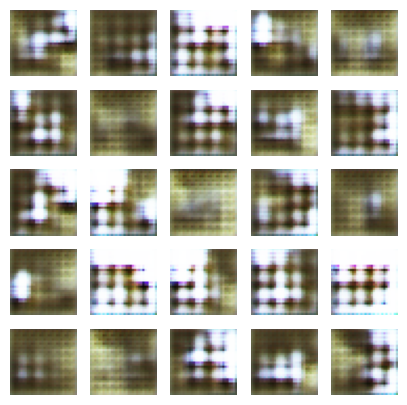

Epoch 11/250: 100%|██████████| 391/391 [00:14<00:00, 27.37batch/s, disc_loss=0.92, gen_loss=1.63] 


Epoch 11/250 - Gen Loss: 1.6220, Disc Loss: 0.9153


Epoch 12/250: 100%|██████████| 391/391 [00:14<00:00, 27.42batch/s, disc_loss=0.901, gen_loss=1.61]


Epoch 12/250 - Gen Loss: 1.6011, Disc Loss: 0.8944


Epoch 13/250: 100%|██████████| 391/391 [00:14<00:00, 27.38batch/s, disc_loss=0.816, gen_loss=1.87]


Epoch 13/250 - Gen Loss: 1.8536, Disc Loss: 0.8102


Epoch 14/250: 100%|██████████| 391/391 [00:14<00:00, 27.26batch/s, disc_loss=0.804, gen_loss=2.06]


Epoch 14/250 - Gen Loss: 2.0496, Disc Loss: 0.8000


Epoch 15/250: 100%|██████████| 391/391 [00:14<00:00, 27.32batch/s, disc_loss=0.729, gen_loss=2.25]


Epoch 15/250 - Gen Loss: 2.2286, Disc Loss: 0.7235


Epoch 16/250: 100%|██████████| 391/391 [00:14<00:00, 27.35batch/s, disc_loss=0.687, gen_loss=2.35]


Epoch 16/250 - Gen Loss: 2.3340, Disc Loss: 0.6813


Epoch 17/250: 100%|██████████| 391/391 [00:14<00:00, 27.16batch/s, disc_loss=0.732, gen_loss=2.02]


Epoch 17/250 - Gen Loss: 2.0065, Disc Loss: 0.7263


Epoch 18/250: 100%|██████████| 391/391 [00:14<00:00, 27.10batch/s, disc_loss=0.867, gen_loss=1.75]


Epoch 18/250 - Gen Loss: 1.7516, Disc Loss: 0.8670


Epoch 19/250: 100%|██████████| 391/391 [00:14<00:00, 27.14batch/s, disc_loss=0.712, gen_loss=1.98]


Epoch 19/250 - Gen Loss: 1.9712, Disc Loss: 0.7084


Epoch 20/250: 100%|██████████| 391/391 [00:14<00:00, 27.19batch/s, disc_loss=0.726, gen_loss=2.23]


Epoch 20/250 - Gen Loss: 2.2226, Disc Loss: 0.7225


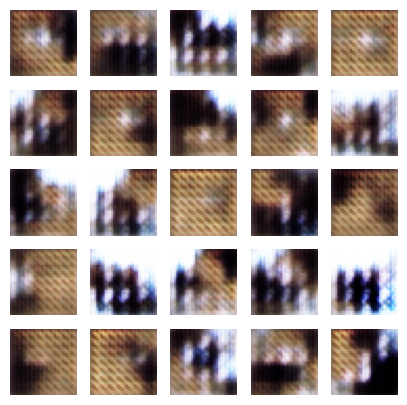

Epoch 21/250: 100%|██████████| 391/391 [00:15<00:00, 25.67batch/s, disc_loss=0.679, gen_loss=2.31]


Epoch 21/250 - Gen Loss: 2.3058, Disc Loss: 0.6776


Epoch 22/250: 100%|██████████| 391/391 [00:13<00:00, 30.04batch/s, disc_loss=0.632, gen_loss=2.11]


Epoch 22/250 - Gen Loss: 2.0913, Disc Loss: 0.6270


Epoch 23/250: 100%|██████████| 391/391 [00:12<00:00, 30.35batch/s, disc_loss=0.748, gen_loss=2.33]


Epoch 23/250 - Gen Loss: 2.3268, Disc Loss: 0.7462


Epoch 24/250: 100%|██████████| 391/391 [00:12<00:00, 30.31batch/s, disc_loss=0.592, gen_loss=2.5] 


Epoch 24/250 - Gen Loss: 2.4856, Disc Loss: 0.5871


Epoch 25/250: 100%|██████████| 391/391 [00:12<00:00, 30.27batch/s, disc_loss=0.53, gen_loss=2.59] 


Epoch 25/250 - Gen Loss: 2.5938, Disc Loss: 0.5299


Epoch 26/250: 100%|██████████| 391/391 [00:12<00:00, 30.32batch/s, disc_loss=0.638, gen_loss=2.4] 


Epoch 26/250 - Gen Loss: 2.3778, Disc Loss: 0.6330


Epoch 27/250: 100%|██████████| 391/391 [00:12<00:00, 30.28batch/s, disc_loss=0.543, gen_loss=2.67]


Epoch 27/250 - Gen Loss: 2.6528, Disc Loss: 0.5387


Epoch 28/250: 100%|██████████| 391/391 [00:12<00:00, 30.37batch/s, disc_loss=0.57, gen_loss=2.48] 


Epoch 28/250 - Gen Loss: 2.4811, Disc Loss: 0.5697


Epoch 29/250: 100%|██████████| 391/391 [00:12<00:00, 30.31batch/s, disc_loss=0.614, gen_loss=2.59]


Epoch 29/250 - Gen Loss: 2.5669, Disc Loss: 0.6090


Epoch 30/250: 100%|██████████| 391/391 [00:12<00:00, 30.31batch/s, disc_loss=0.556, gen_loss=2.5] 


Epoch 30/250 - Gen Loss: 2.4808, Disc Loss: 0.5521


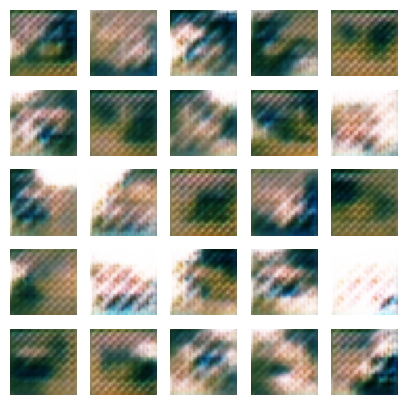

Epoch 31/250: 100%|██████████| 391/391 [00:12<00:00, 30.31batch/s, disc_loss=0.527, gen_loss=2.88]


Epoch 31/250 - Gen Loss: 2.8841, Disc Loss: 0.5274


Epoch 32/250: 100%|██████████| 391/391 [00:12<00:00, 30.29batch/s, disc_loss=0.542, gen_loss=2.89]


Epoch 32/250 - Gen Loss: 2.8890, Disc Loss: 0.5416


Epoch 33/250: 100%|██████████| 391/391 [00:12<00:00, 30.32batch/s, disc_loss=0.498, gen_loss=2.97]


Epoch 33/250 - Gen Loss: 2.9423, Disc Loss: 0.4945


Epoch 34/250: 100%|██████████| 391/391 [00:12<00:00, 31.07batch/s, disc_loss=0.451, gen_loss=3.03]


Epoch 34/250 - Gen Loss: 3.0080, Disc Loss: 0.4473


Epoch 35/250: 100%|██████████| 391/391 [00:12<00:00, 31.10batch/s, disc_loss=0.512, gen_loss=2.9] 


Epoch 35/250 - Gen Loss: 2.8734, Disc Loss: 0.5080


Epoch 36/250: 100%|██████████| 391/391 [00:14<00:00, 27.40batch/s, disc_loss=0.462, gen_loss=2.98]


Epoch 36/250 - Gen Loss: 2.9643, Disc Loss: 0.4596


Epoch 37/250: 100%|██████████| 391/391 [00:13<00:00, 29.55batch/s, disc_loss=0.427, gen_loss=3.4] 


Epoch 37/250 - Gen Loss: 3.3868, Disc Loss: 0.4262


Epoch 38/250: 100%|██████████| 391/391 [00:12<00:00, 30.38batch/s, disc_loss=0.384, gen_loss=3.63]


Epoch 38/250 - Gen Loss: 3.6271, Disc Loss: 0.3839


Epoch 39/250: 100%|██████████| 391/391 [00:12<00:00, 30.34batch/s, disc_loss=0.427, gen_loss=3.2] 


Epoch 39/250 - Gen Loss: 3.1707, Disc Loss: 0.4241


Epoch 40/250: 100%|██████████| 391/391 [00:12<00:00, 30.30batch/s, disc_loss=0.492, gen_loss=3.02]


Epoch 40/250 - Gen Loss: 2.9937, Disc Loss: 0.4885


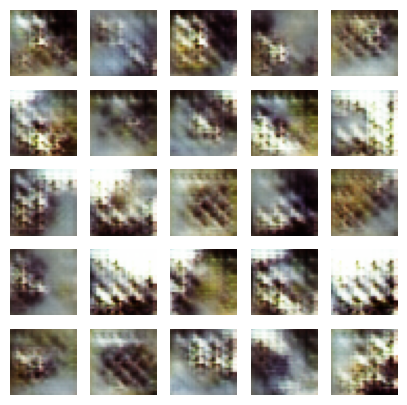

Epoch 41/250: 100%|██████████| 391/391 [00:12<00:00, 30.32batch/s, disc_loss=0.507, gen_loss=3.67]


Epoch 41/250 - Gen Loss: 3.6401, Disc Loss: 0.5032


Epoch 42/250: 100%|██████████| 391/391 [00:12<00:00, 30.30batch/s, disc_loss=0.462, gen_loss=3.08]


Epoch 42/250 - Gen Loss: 3.0537, Disc Loss: 0.4585


Epoch 43/250: 100%|██████████| 391/391 [00:12<00:00, 31.08batch/s, disc_loss=0.479, gen_loss=3.25]


Epoch 43/250 - Gen Loss: 3.2299, Disc Loss: 0.4758


Epoch 44/250: 100%|██████████| 391/391 [00:12<00:00, 31.13batch/s, disc_loss=0.468, gen_loss=3.21]


Epoch 44/250 - Gen Loss: 3.1818, Disc Loss: 0.4648


Epoch 45/250: 100%|██████████| 391/391 [00:12<00:00, 31.12batch/s, disc_loss=0.384, gen_loss=3.69]


Epoch 45/250 - Gen Loss: 3.6591, Disc Loss: 0.3810


Epoch 46/250: 100%|██████████| 391/391 [00:12<00:00, 30.51batch/s, disc_loss=0.366, gen_loss=3.55]


Epoch 46/250 - Gen Loss: 3.5345, Disc Loss: 0.3640


Epoch 47/250: 100%|██████████| 391/391 [00:12<00:00, 30.22batch/s, disc_loss=0.344, gen_loss=3.85]


Epoch 47/250 - Gen Loss: 3.8522, Disc Loss: 0.3439


Epoch 48/250: 100%|██████████| 391/391 [00:12<00:00, 31.90batch/s, disc_loss=0.323, gen_loss=3.95]


Epoch 48/250 - Gen Loss: 3.9299, Disc Loss: 0.3216


Epoch 49/250: 100%|██████████| 391/391 [00:12<00:00, 30.91batch/s, disc_loss=0.38, gen_loss=3.37] 


Epoch 49/250 - Gen Loss: 3.3566, Disc Loss: 0.3783


Epoch 50/250: 100%|██████████| 391/391 [00:12<00:00, 31.50batch/s, disc_loss=0.374, gen_loss=3.5] 


Epoch 50/250 - Gen Loss: 3.4931, Disc Loss: 0.3733


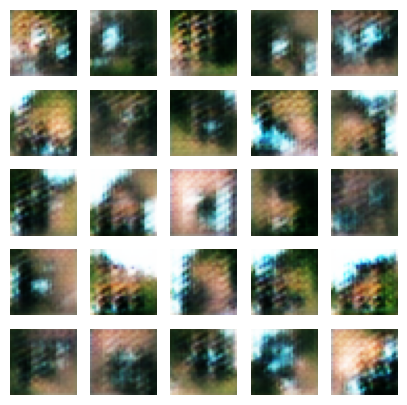

Epoch 51/250: 100%|██████████| 391/391 [00:12<00:00, 31.52batch/s, disc_loss=0.43, gen_loss=3.4]  


Epoch 51/250 - Gen Loss: 3.3970, Disc Loss: 0.4298


Epoch 52/250: 100%|██████████| 391/391 [00:12<00:00, 31.18batch/s, disc_loss=0.397, gen_loss=3.57]


Epoch 52/250 - Gen Loss: 3.5564, Disc Loss: 0.3951


Epoch 53/250: 100%|██████████| 391/391 [00:12<00:00, 30.60batch/s, disc_loss=0.366, gen_loss=3.75]


Epoch 53/250 - Gen Loss: 3.7325, Disc Loss: 0.3637


Epoch 54/250: 100%|██████████| 391/391 [00:12<00:00, 32.55batch/s, disc_loss=0.373, gen_loss=3.56]


Epoch 54/250 - Gen Loss: 3.5479, Disc Loss: 0.3723


Epoch 55/250: 100%|██████████| 391/391 [00:12<00:00, 31.69batch/s, disc_loss=0.351, gen_loss=3.6] 


Epoch 55/250 - Gen Loss: 3.5677, Disc Loss: 0.3487


Epoch 56/250: 100%|██████████| 391/391 [00:12<00:00, 31.85batch/s, disc_loss=0.397, gen_loss=3.44]


Epoch 56/250 - Gen Loss: 3.4406, Disc Loss: 0.3970


Epoch 57/250: 100%|██████████| 391/391 [00:12<00:00, 31.67batch/s, disc_loss=0.436, gen_loss=3.34]


Epoch 57/250 - Gen Loss: 3.3312, Disc Loss: 0.4349


Epoch 58/250: 100%|██████████| 391/391 [00:12<00:00, 30.86batch/s, disc_loss=0.422, gen_loss=3.1] 


Epoch 58/250 - Gen Loss: 3.1005, Disc Loss: 0.4215


Epoch 59/250: 100%|██████████| 391/391 [00:11<00:00, 32.60batch/s, disc_loss=0.353, gen_loss=4.18]


Epoch 59/250 - Gen Loss: 4.1481, Disc Loss: 0.3500


Epoch 60/250: 100%|██████████| 391/391 [00:12<00:00, 30.81batch/s, disc_loss=0.44, gen_loss=3.25] 


Epoch 60/250 - Gen Loss: 3.2378, Disc Loss: 0.4393


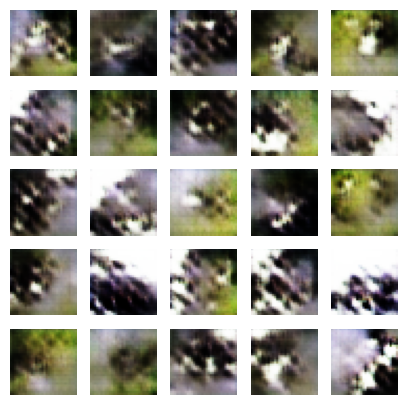

Epoch 61/250: 100%|██████████| 391/391 [00:12<00:00, 31.55batch/s, disc_loss=0.358, gen_loss=3.71]


Epoch 61/250 - Gen Loss: 3.7025, Disc Loss: 0.3566


Epoch 62/250: 100%|██████████| 391/391 [00:12<00:00, 32.40batch/s, disc_loss=0.379, gen_loss=3.58]


Epoch 62/250 - Gen Loss: 3.5771, Disc Loss: 0.3785


Epoch 63/250: 100%|██████████| 391/391 [00:13<00:00, 28.46batch/s, disc_loss=0.407, gen_loss=3.31]


Epoch 63/250 - Gen Loss: 3.3123, Disc Loss: 0.4069


Epoch 64/250: 100%|██████████| 391/391 [00:13<00:00, 29.72batch/s, disc_loss=0.396, gen_loss=3.49]


Epoch 64/250 - Gen Loss: 3.4708, Disc Loss: 0.3940


Epoch 65/250: 100%|██████████| 391/391 [00:13<00:00, 29.78batch/s, disc_loss=0.423, gen_loss=3.7] 


Epoch 65/250 - Gen Loss: 3.6707, Disc Loss: 0.4194


Epoch 66/250: 100%|██████████| 391/391 [00:12<00:00, 30.77batch/s, disc_loss=0.415, gen_loss=3.29]


Epoch 66/250 - Gen Loss: 3.2743, Disc Loss: 0.4129


Epoch 67/250: 100%|██████████| 391/391 [00:12<00:00, 31.57batch/s, disc_loss=0.439, gen_loss=3.07]


Epoch 67/250 - Gen Loss: 3.0668, Disc Loss: 0.4394


Epoch 68/250: 100%|██████████| 391/391 [00:14<00:00, 27.55batch/s, disc_loss=0.395, gen_loss=3.34]


Epoch 68/250 - Gen Loss: 3.3122, Disc Loss: 0.3915


Epoch 69/250: 100%|██████████| 391/391 [00:12<00:00, 30.95batch/s, disc_loss=0.439, gen_loss=3.34]


Epoch 69/250 - Gen Loss: 3.3108, Disc Loss: 0.4353


Epoch 70/250: 100%|██████████| 391/391 [00:12<00:00, 30.62batch/s, disc_loss=0.433, gen_loss=3.22]


Epoch 70/250 - Gen Loss: 3.1946, Disc Loss: 0.4292


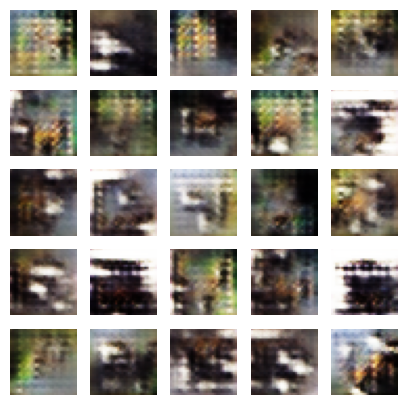

Epoch 71/250: 100%|██████████| 391/391 [00:13<00:00, 29.76batch/s, disc_loss=0.411, gen_loss=3.34]


Epoch 71/250 - Gen Loss: 3.3206, Disc Loss: 0.4085


Epoch 72/250: 100%|██████████| 391/391 [00:12<00:00, 31.19batch/s, disc_loss=0.421, gen_loss=3.31]


Epoch 72/250 - Gen Loss: 3.3072, Disc Loss: 0.4206


Epoch 73/250: 100%|██████████| 391/391 [00:11<00:00, 32.98batch/s, disc_loss=0.398, gen_loss=3.71]


Epoch 73/250 - Gen Loss: 3.6860, Disc Loss: 0.3953


Epoch 74/250: 100%|██████████| 391/391 [00:11<00:00, 32.92batch/s, disc_loss=0.341, gen_loss=3.73]


Epoch 74/250 - Gen Loss: 3.7343, Disc Loss: 0.3410


Epoch 75/250: 100%|██████████| 391/391 [00:11<00:00, 32.96batch/s, disc_loss=0.461, gen_loss=3.17]


Epoch 75/250 - Gen Loss: 3.1411, Disc Loss: 0.4575


Epoch 76/250: 100%|██████████| 391/391 [00:11<00:00, 32.70batch/s, disc_loss=0.395, gen_loss=3.42]


Epoch 76/250 - Gen Loss: 3.4156, Disc Loss: 0.3946


Epoch 77/250: 100%|██████████| 391/391 [00:11<00:00, 32.92batch/s, disc_loss=0.417, gen_loss=3.61]


Epoch 77/250 - Gen Loss: 3.5820, Disc Loss: 0.4136


Epoch 78/250: 100%|██████████| 391/391 [00:11<00:00, 32.87batch/s, disc_loss=0.404, gen_loss=3.5] 


Epoch 78/250 - Gen Loss: 3.4983, Disc Loss: 0.4039


Epoch 79/250: 100%|██████████| 391/391 [00:11<00:00, 32.93batch/s, disc_loss=0.423, gen_loss=3.13]


Epoch 79/250 - Gen Loss: 3.1038, Disc Loss: 0.4193


Epoch 80/250: 100%|██████████| 391/391 [00:11<00:00, 32.83batch/s, disc_loss=0.458, gen_loss=3.11]


Epoch 80/250 - Gen Loss: 3.1092, Disc Loss: 0.4580


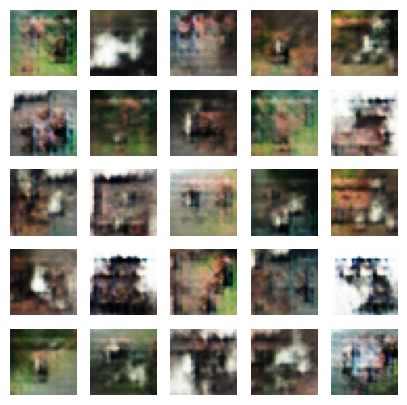

Epoch 81/250: 100%|██████████| 391/391 [00:11<00:00, 32.73batch/s, disc_loss=0.482, gen_loss=2.93]


Epoch 81/250 - Gen Loss: 2.9255, Disc Loss: 0.4816


Epoch 82/250: 100%|██████████| 391/391 [00:11<00:00, 32.90batch/s, disc_loss=0.511, gen_loss=3.23]


Epoch 82/250 - Gen Loss: 3.2072, Disc Loss: 0.5070


Epoch 83/250: 100%|██████████| 391/391 [00:11<00:00, 32.64batch/s, disc_loss=0.464, gen_loss=2.82]


Epoch 83/250 - Gen Loss: 2.8235, Disc Loss: 0.4645


Epoch 84/250: 100%|██████████| 391/391 [00:11<00:00, 32.80batch/s, disc_loss=0.465, gen_loss=3.09]


Epoch 84/250 - Gen Loss: 3.0665, Disc Loss: 0.4613


Epoch 85/250: 100%|██████████| 391/391 [00:11<00:00, 32.74batch/s, disc_loss=0.48, gen_loss=2.95] 


Epoch 85/250 - Gen Loss: 2.9488, Disc Loss: 0.4803


Epoch 86/250: 100%|██████████| 391/391 [00:11<00:00, 32.66batch/s, disc_loss=0.487, gen_loss=2.93]


Epoch 86/250 - Gen Loss: 2.9043, Disc Loss: 0.4833


Epoch 87/250: 100%|██████████| 391/391 [00:11<00:00, 32.65batch/s, disc_loss=0.494, gen_loss=3.04]


Epoch 87/250 - Gen Loss: 3.0183, Disc Loss: 0.4907


Epoch 88/250: 100%|██████████| 391/391 [00:12<00:00, 31.96batch/s, disc_loss=0.486, gen_loss=2.92]


Epoch 88/250 - Gen Loss: 2.8931, Disc Loss: 0.4821


Epoch 89/250: 100%|██████████| 391/391 [00:12<00:00, 30.45batch/s, disc_loss=0.508, gen_loss=2.96]


Epoch 89/250 - Gen Loss: 2.9373, Disc Loss: 0.5045


Epoch 90/250: 100%|██████████| 391/391 [00:12<00:00, 31.95batch/s, disc_loss=0.481, gen_loss=2.78]


Epoch 90/250 - Gen Loss: 2.7604, Disc Loss: 0.4778


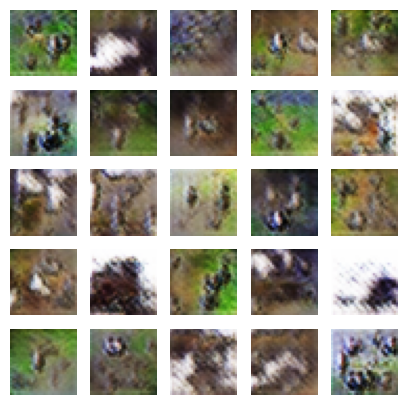

Epoch 91/250: 100%|██████████| 391/391 [00:12<00:00, 31.47batch/s, disc_loss=0.45, gen_loss=3.15] 


Epoch 91/250 - Gen Loss: 3.1414, Disc Loss: 0.4484


Epoch 92/250: 100%|██████████| 391/391 [00:11<00:00, 32.82batch/s, disc_loss=0.491, gen_loss=2.88]


Epoch 92/250 - Gen Loss: 2.8593, Disc Loss: 0.4869


Epoch 93/250: 100%|██████████| 391/391 [00:11<00:00, 32.89batch/s, disc_loss=0.494, gen_loss=3.72]


Epoch 93/250 - Gen Loss: 3.6867, Disc Loss: 0.4901


Epoch 94/250: 100%|██████████| 391/391 [00:11<00:00, 32.73batch/s, disc_loss=0.423, gen_loss=3.15]


Epoch 94/250 - Gen Loss: 3.1231, Disc Loss: 0.4197


Epoch 95/250: 100%|██████████| 391/391 [00:11<00:00, 32.84batch/s, disc_loss=0.434, gen_loss=2.98]


Epoch 95/250 - Gen Loss: 2.9582, Disc Loss: 0.4308


Epoch 96/250: 100%|██████████| 391/391 [00:12<00:00, 32.29batch/s, disc_loss=0.454, gen_loss=3.13]


Epoch 96/250 - Gen Loss: 3.1057, Disc Loss: 0.4507


Epoch 97/250: 100%|██████████| 391/391 [00:12<00:00, 30.36batch/s, disc_loss=0.502, gen_loss=3.02]


Epoch 97/250 - Gen Loss: 3.0009, Disc Loss: 0.4996


Epoch 98/250: 100%|██████████| 391/391 [00:12<00:00, 31.30batch/s, disc_loss=0.48, gen_loss=2.9]  


Epoch 98/250 - Gen Loss: 2.8782, Disc Loss: 0.4761


Epoch 99/250: 100%|██████████| 391/391 [00:11<00:00, 32.84batch/s, disc_loss=0.522, gen_loss=3.23]


Epoch 99/250 - Gen Loss: 3.2044, Disc Loss: 0.5177


Epoch 100/250: 100%|██████████| 391/391 [00:11<00:00, 32.86batch/s, disc_loss=0.507, gen_loss=2.79]


Epoch 100/250 - Gen Loss: 2.7730, Disc Loss: 0.5028


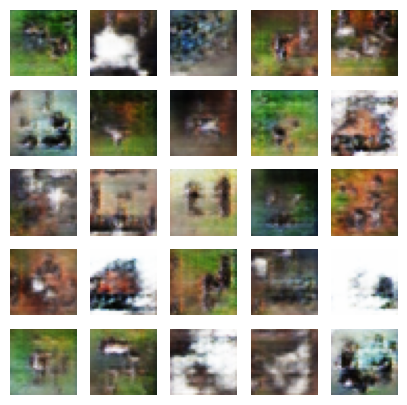

Epoch 101/250: 100%|██████████| 391/391 [00:11<00:00, 32.74batch/s, disc_loss=0.534, gen_loss=2.66]


Epoch 101/250 - Gen Loss: 2.6433, Disc Loss: 0.5299


Epoch 102/250: 100%|██████████| 391/391 [00:11<00:00, 32.83batch/s, disc_loss=0.517, gen_loss=2.73]


Epoch 102/250 - Gen Loss: 2.7085, Disc Loss: 0.5128


Epoch 103/250: 100%|██████████| 391/391 [00:11<00:00, 32.85batch/s, disc_loss=0.539, gen_loss=2.61]


Epoch 103/250 - Gen Loss: 2.5901, Disc Loss: 0.5345


Epoch 104/250: 100%|██████████| 391/391 [00:11<00:00, 32.81batch/s, disc_loss=0.514, gen_loss=3]   


Epoch 104/250 - Gen Loss: 2.9722, Disc Loss: 0.5100


Epoch 105/250: 100%|██████████| 391/391 [00:11<00:00, 32.82batch/s, disc_loss=0.518, gen_loss=2.75]


Epoch 105/250 - Gen Loss: 2.7279, Disc Loss: 0.5145


Epoch 106/250: 100%|██████████| 391/391 [00:11<00:00, 32.79batch/s, disc_loss=0.557, gen_loss=2.53]


Epoch 106/250 - Gen Loss: 2.5318, Disc Loss: 0.5569


Epoch 107/250: 100%|██████████| 391/391 [00:11<00:00, 32.82batch/s, disc_loss=0.582, gen_loss=2.53]


Epoch 107/250 - Gen Loss: 2.5125, Disc Loss: 0.5775


Epoch 108/250: 100%|██████████| 391/391 [00:11<00:00, 32.77batch/s, disc_loss=0.566, gen_loss=2.5] 


Epoch 108/250 - Gen Loss: 2.4759, Disc Loss: 0.5616


Epoch 109/250: 100%|██████████| 391/391 [00:11<00:00, 32.78batch/s, disc_loss=0.625, gen_loss=2.4] 


Epoch 109/250 - Gen Loss: 2.3855, Disc Loss: 0.6199


Epoch 110/250: 100%|██████████| 391/391 [00:11<00:00, 32.78batch/s, disc_loss=0.63, gen_loss=2.28] 


Epoch 110/250 - Gen Loss: 2.2667, Disc Loss: 0.6254


Epoch 111/250: 100%|██████████| 391/391 [00:11<00:00, 32.78batch/s, disc_loss=0.648, gen_loss=2.24]


Epoch 111/250 - Gen Loss: 2.2193, Disc Loss: 0.6432


Epoch 112/250: 100%|██████████| 391/391 [00:12<00:00, 31.26batch/s, disc_loss=0.669, gen_loss=2.14]


Epoch 112/250 - Gen Loss: 2.1366, Disc Loss: 0.6671


Epoch 113/250: 100%|██████████| 391/391 [00:11<00:00, 32.79batch/s, disc_loss=0.69, gen_loss=2.1]  


Epoch 113/250 - Gen Loss: 2.0832, Disc Loss: 0.6850


Epoch 114/250: 100%|██████████| 391/391 [00:11<00:00, 32.70batch/s, disc_loss=0.729, gen_loss=2.01]


Epoch 114/250 - Gen Loss: 2.0079, Disc Loss: 0.7291


Epoch 115/250: 100%|██████████| 391/391 [00:11<00:00, 32.73batch/s, disc_loss=0.748, gen_loss=2.01]


Epoch 115/250 - Gen Loss: 1.9962, Disc Loss: 0.7424


Epoch 116/250: 100%|██████████| 391/391 [00:11<00:00, 32.75batch/s, disc_loss=0.729, gen_loss=3.07]


Epoch 116/250 - Gen Loss: 3.0479, Disc Loss: 0.7232


Epoch 117/250: 100%|██████████| 391/391 [00:11<00:00, 32.75batch/s, disc_loss=0.709, gen_loss=2.39]


Epoch 117/250 - Gen Loss: 2.3912, Disc Loss: 0.7092


Epoch 118/250: 100%|██████████| 391/391 [00:11<00:00, 32.68batch/s, disc_loss=0.715, gen_loss=2.01]


Epoch 118/250 - Gen Loss: 1.9944, Disc Loss: 0.7099


Epoch 119/250: 100%|██████████| 391/391 [00:12<00:00, 32.58batch/s, disc_loss=0.766, gen_loss=1.82]


Epoch 119/250 - Gen Loss: 1.8169, Disc Loss: 0.7665


Epoch 120/250: 100%|██████████| 391/391 [00:12<00:00, 31.92batch/s, disc_loss=0.781, gen_loss=1.9] 


Epoch 120/250 - Gen Loss: 1.8930, Disc Loss: 0.7787


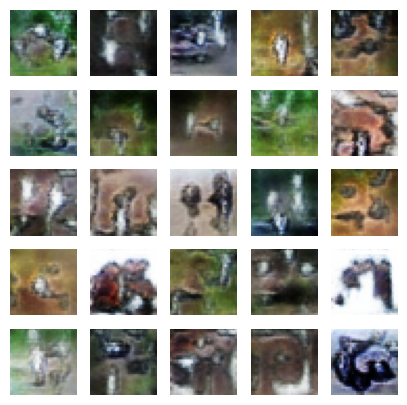

Epoch 121/250: 100%|██████████| 391/391 [00:12<00:00, 30.91batch/s, disc_loss=0.809, gen_loss=1.69]


Epoch 121/250 - Gen Loss: 1.6825, Disc Loss: 0.8046


Epoch 122/250: 100%|██████████| 391/391 [00:12<00:00, 31.65batch/s, disc_loss=0.797, gen_loss=1.8] 


Epoch 122/250 - Gen Loss: 1.7889, Disc Loss: 0.7934


Epoch 123/250: 100%|██████████| 391/391 [00:12<00:00, 31.67batch/s, disc_loss=0.766, gen_loss=2.4] 


Epoch 123/250 - Gen Loss: 2.3832, Disc Loss: 0.7597


Epoch 124/250: 100%|██████████| 391/391 [00:11<00:00, 32.81batch/s, disc_loss=0.671, gen_loss=2.63]


Epoch 124/250 - Gen Loss: 2.6140, Disc Loss: 0.6656


Epoch 125/250: 100%|██████████| 391/391 [00:11<00:00, 32.69batch/s, disc_loss=0.749, gen_loss=1.9] 


Epoch 125/250 - Gen Loss: 1.9010, Disc Loss: 0.7487


Epoch 126/250: 100%|██████████| 391/391 [00:11<00:00, 32.76batch/s, disc_loss=0.859, gen_loss=1.62]


Epoch 126/250 - Gen Loss: 1.6121, Disc Loss: 0.8528


Epoch 127/250: 100%|██████████| 391/391 [00:12<00:00, 31.40batch/s, disc_loss=0.834, gen_loss=1.67]


Epoch 127/250 - Gen Loss: 1.6696, Disc Loss: 0.8340


Epoch 128/250: 100%|██████████| 391/391 [00:12<00:00, 32.35batch/s, disc_loss=0.849, gen_loss=1.6] 


Epoch 128/250 - Gen Loss: 1.5993, Disc Loss: 0.8490


Epoch 129/250: 100%|██████████| 391/391 [00:12<00:00, 31.99batch/s, disc_loss=0.895, gen_loss=1.95]


Epoch 129/250 - Gen Loss: 1.9319, Disc Loss: 0.8882


Epoch 130/250: 100%|██████████| 391/391 [00:12<00:00, 30.41batch/s, disc_loss=0.9, gen_loss=1.6]   


Epoch 130/250 - Gen Loss: 1.5891, Disc Loss: 0.8935


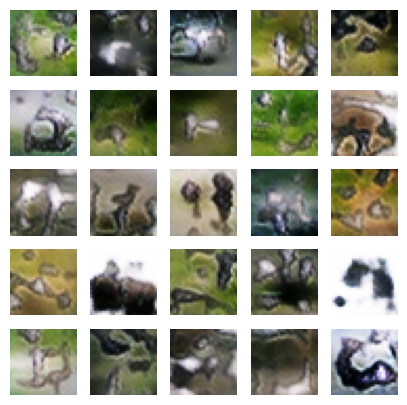

Epoch 131/250: 100%|██████████| 391/391 [00:12<00:00, 30.74batch/s, disc_loss=0.87, gen_loss=2.02] 


Epoch 131/250 - Gen Loss: 2.0093, Disc Loss: 0.8634


Epoch 132/250: 100%|██████████| 391/391 [00:12<00:00, 32.46batch/s, disc_loss=0.862, gen_loss=1.52]


Epoch 132/250 - Gen Loss: 1.5234, Disc Loss: 0.8622


Epoch 133/250: 100%|██████████| 391/391 [00:12<00:00, 32.36batch/s, disc_loss=0.906, gen_loss=1.6] 


Epoch 133/250 - Gen Loss: 1.5847, Disc Loss: 0.8991


Epoch 134/250: 100%|██████████| 391/391 [00:12<00:00, 32.26batch/s, disc_loss=0.864, gen_loss=1.59]


Epoch 134/250 - Gen Loss: 1.5877, Disc Loss: 0.8642


Epoch 135/250: 100%|██████████| 391/391 [00:12<00:00, 32.58batch/s, disc_loss=0.886, gen_loss=1.51]


Epoch 135/250 - Gen Loss: 1.5128, Disc Loss: 0.8862


Epoch 136/250: 100%|██████████| 391/391 [00:13<00:00, 28.81batch/s, disc_loss=0.886, gen_loss=1.62]


Epoch 136/250 - Gen Loss: 1.6128, Disc Loss: 0.8816


Epoch 137/250: 100%|██████████| 391/391 [00:13<00:00, 29.94batch/s, disc_loss=0.898, gen_loss=1.6] 


Epoch 137/250 - Gen Loss: 1.5956, Disc Loss: 0.8983


Epoch 138/250: 100%|██████████| 391/391 [00:12<00:00, 30.69batch/s, disc_loss=0.852, gen_loss=1.8] 


Epoch 138/250 - Gen Loss: 1.7907, Disc Loss: 0.8455


Epoch 139/250: 100%|██████████| 391/391 [00:12<00:00, 30.35batch/s, disc_loss=0.891, gen_loss=1.53]


Epoch 139/250 - Gen Loss: 1.5263, Disc Loss: 0.8867


Epoch 140/250: 100%|██████████| 391/391 [00:12<00:00, 30.36batch/s, disc_loss=0.864, gen_loss=1.48]


Epoch 140/250 - Gen Loss: 1.4761, Disc Loss: 0.8645


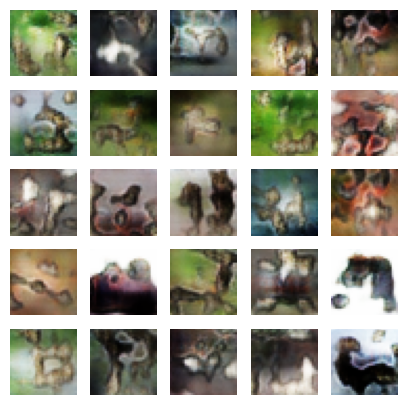

Epoch 141/250: 100%|██████████| 391/391 [00:13<00:00, 29.85batch/s, disc_loss=0.866, gen_loss=1.5] 


Epoch 141/250 - Gen Loss: 1.4970, Disc Loss: 0.8664


Epoch 142/250: 100%|██████████| 391/391 [00:12<00:00, 30.87batch/s, disc_loss=0.88, gen_loss=1.56] 


Epoch 142/250 - Gen Loss: 1.5644, Disc Loss: 0.8804


Epoch 143/250: 100%|██████████| 391/391 [00:12<00:00, 30.52batch/s, disc_loss=1.02, gen_loss=1.82]


Epoch 143/250 - Gen Loss: 1.8200, Disc Loss: 1.0226


Epoch 144/250: 100%|██████████| 391/391 [00:12<00:00, 30.46batch/s, disc_loss=0.931, gen_loss=1.42]


Epoch 144/250 - Gen Loss: 1.4081, Disc Loss: 0.9242


Epoch 145/250: 100%|██████████| 391/391 [00:12<00:00, 30.33batch/s, disc_loss=0.918, gen_loss=1.42]


Epoch 145/250 - Gen Loss: 1.4127, Disc Loss: 0.9133


Epoch 146/250: 100%|██████████| 391/391 [00:12<00:00, 31.63batch/s, disc_loss=0.924, gen_loss=1.43]


Epoch 146/250 - Gen Loss: 1.4239, Disc Loss: 0.9173


Epoch 147/250: 100%|██████████| 391/391 [00:12<00:00, 31.93batch/s, disc_loss=0.911, gen_loss=1.49]


Epoch 147/250 - Gen Loss: 1.4810, Disc Loss: 0.9063


Epoch 148/250: 100%|██████████| 391/391 [00:12<00:00, 32.52batch/s, disc_loss=0.923, gen_loss=1.43]


Epoch 148/250 - Gen Loss: 1.4183, Disc Loss: 0.9156


Epoch 149/250: 100%|██████████| 391/391 [00:12<00:00, 31.80batch/s, disc_loss=0.935, gen_loss=1.53]


Epoch 149/250 - Gen Loss: 1.5186, Disc Loss: 0.9301


Epoch 150/250: 100%|██████████| 391/391 [00:12<00:00, 32.31batch/s, disc_loss=0.915, gen_loss=1.77]


Epoch 150/250 - Gen Loss: 1.7663, Disc Loss: 0.9152


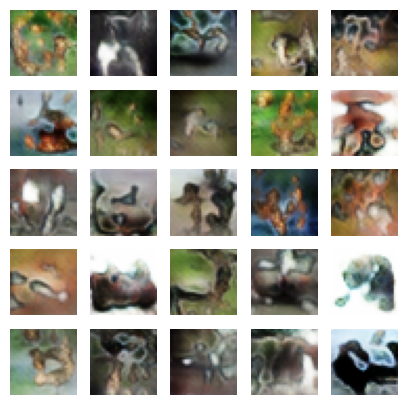

Epoch 151/250: 100%|██████████| 391/391 [00:12<00:00, 32.25batch/s, disc_loss=0.94, gen_loss=1.36] 


Epoch 151/250 - Gen Loss: 1.3632, Disc Loss: 0.9400


Epoch 152/250: 100%|██████████| 391/391 [00:11<00:00, 32.85batch/s, disc_loss=0.927, gen_loss=1.41]


Epoch 152/250 - Gen Loss: 1.3987, Disc Loss: 0.9203


Epoch 153/250: 100%|██████████| 391/391 [00:11<00:00, 32.84batch/s, disc_loss=0.953, gen_loss=1.4] 


Epoch 153/250 - Gen Loss: 1.3843, Disc Loss: 0.9457


Epoch 154/250: 100%|██████████| 391/391 [00:11<00:00, 32.79batch/s, disc_loss=0.945, gen_loss=1.4] 


Epoch 154/250 - Gen Loss: 1.3901, Disc Loss: 0.9382


Epoch 155/250: 100%|██████████| 391/391 [00:11<00:00, 32.76batch/s, disc_loss=0.955, gen_loss=1.51]


Epoch 155/250 - Gen Loss: 1.5020, Disc Loss: 0.9476


Epoch 156/250: 100%|██████████| 391/391 [00:12<00:00, 31.61batch/s, disc_loss=0.932, gen_loss=1.41]


Epoch 156/250 - Gen Loss: 1.4104, Disc Loss: 0.9320


Epoch 157/250: 100%|██████████| 391/391 [00:12<00:00, 32.54batch/s, disc_loss=0.94, gen_loss=1.45] 


Epoch 157/250 - Gen Loss: 1.4400, Disc Loss: 0.9332


Epoch 158/250: 100%|██████████| 391/391 [00:12<00:00, 32.37batch/s, disc_loss=0.942, gen_loss=1.43]


Epoch 158/250 - Gen Loss: 1.4327, Disc Loss: 0.9421


Epoch 159/250: 100%|██████████| 391/391 [00:11<00:00, 32.85batch/s, disc_loss=0.932, gen_loss=1.4] 


Epoch 159/250 - Gen Loss: 1.3918, Disc Loss: 0.9244


Epoch 160/250: 100%|██████████| 391/391 [00:11<00:00, 32.82batch/s, disc_loss=0.947, gen_loss=1.49]


Epoch 160/250 - Gen Loss: 1.4794, Disc Loss: 0.9393


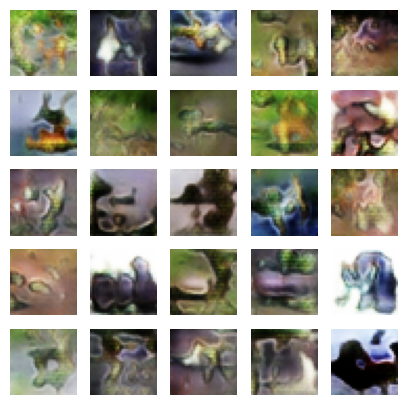

Epoch 161/250: 100%|██████████| 391/391 [00:11<00:00, 32.79batch/s, disc_loss=0.938, gen_loss=1.45]


Epoch 161/250 - Gen Loss: 1.4391, Disc Loss: 0.9313


Epoch 162/250: 100%|██████████| 391/391 [00:11<00:00, 32.83batch/s, disc_loss=0.945, gen_loss=1.5] 


Epoch 162/250 - Gen Loss: 1.4908, Disc Loss: 0.9377


Epoch 163/250: 100%|██████████| 391/391 [00:11<00:00, 32.78batch/s, disc_loss=0.944, gen_loss=1.42]


Epoch 163/250 - Gen Loss: 1.4108, Disc Loss: 0.9371


Epoch 164/250: 100%|██████████| 391/391 [00:11<00:00, 32.69batch/s, disc_loss=0.936, gen_loss=1.46]


Epoch 164/250 - Gen Loss: 1.4499, Disc Loss: 0.9290


Epoch 165/250: 100%|██████████| 391/391 [00:12<00:00, 31.61batch/s, disc_loss=0.917, gen_loss=1.45]


Epoch 165/250 - Gen Loss: 1.4409, Disc Loss: 0.9097


Epoch 166/250: 100%|██████████| 391/391 [00:12<00:00, 31.82batch/s, disc_loss=0.92, gen_loss=1.53] 


Epoch 166/250 - Gen Loss: 1.5326, Disc Loss: 0.9197


Epoch 167/250: 100%|██████████| 391/391 [00:11<00:00, 32.85batch/s, disc_loss=0.959, gen_loss=1.65]


Epoch 167/250 - Gen Loss: 1.6362, Disc Loss: 0.9512


Epoch 168/250: 100%|██████████| 391/391 [00:11<00:00, 32.84batch/s, disc_loss=0.937, gen_loss=1.48]


Epoch 168/250 - Gen Loss: 1.4732, Disc Loss: 0.9302


Epoch 169/250: 100%|██████████| 391/391 [00:11<00:00, 32.79batch/s, disc_loss=0.918, gen_loss=1.43]


Epoch 169/250 - Gen Loss: 1.4201, Disc Loss: 0.9110


Epoch 170/250: 100%|██████████| 391/391 [00:11<00:00, 32.72batch/s, disc_loss=0.926, gen_loss=1.45]


Epoch 170/250 - Gen Loss: 1.4408, Disc Loss: 0.9191


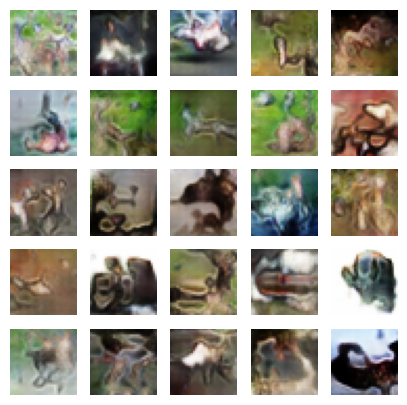

Epoch 171/250: 100%|██████████| 391/391 [00:12<00:00, 31.16batch/s, disc_loss=0.924, gen_loss=1.5] 


Epoch 171/250 - Gen Loss: 1.4936, Disc Loss: 0.9192


Epoch 172/250: 100%|██████████| 391/391 [00:12<00:00, 32.23batch/s, disc_loss=0.924, gen_loss=1.48]


Epoch 172/250 - Gen Loss: 1.4715, Disc Loss: 0.9171


Epoch 173/250: 100%|██████████| 391/391 [00:12<00:00, 32.55batch/s, disc_loss=0.943, gen_loss=1.48]


Epoch 173/250 - Gen Loss: 1.4679, Disc Loss: 0.9353


Epoch 174/250: 100%|██████████| 391/391 [00:11<00:00, 32.81batch/s, disc_loss=0.958, gen_loss=1.48]


Epoch 174/250 - Gen Loss: 1.4708, Disc Loss: 0.9504


Epoch 175/250: 100%|██████████| 391/391 [00:11<00:00, 32.93batch/s, disc_loss=0.939, gen_loss=1.99]


Epoch 175/250 - Gen Loss: 1.9740, Disc Loss: 0.9320


Epoch 176/250: 100%|██████████| 391/391 [00:11<00:00, 32.89batch/s, disc_loss=0.954, gen_loss=1.44]


Epoch 176/250 - Gen Loss: 1.4280, Disc Loss: 0.9468


Epoch 177/250: 100%|██████████| 391/391 [00:11<00:00, 32.89batch/s, disc_loss=0.946, gen_loss=1.37]


Epoch 177/250 - Gen Loss: 1.3549, Disc Loss: 0.9384


Epoch 178/250: 100%|██████████| 391/391 [00:11<00:00, 32.90batch/s, disc_loss=0.956, gen_loss=1.42]


Epoch 178/250 - Gen Loss: 1.4044, Disc Loss: 0.9490


Epoch 179/250: 100%|██████████| 391/391 [00:11<00:00, 32.89batch/s, disc_loss=0.955, gen_loss=1.45]


Epoch 179/250 - Gen Loss: 1.4388, Disc Loss: 0.9476


Epoch 180/250: 100%|██████████| 391/391 [00:11<00:00, 32.89batch/s, disc_loss=0.953, gen_loss=1.39]


Epoch 180/250 - Gen Loss: 1.3818, Disc Loss: 0.9460


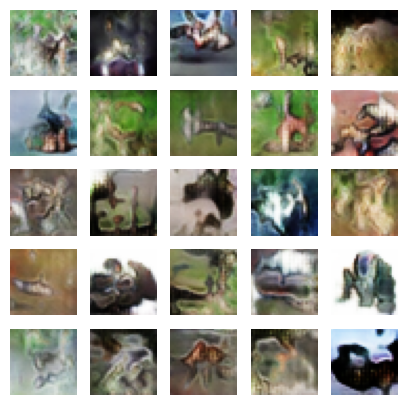

Epoch 181/250: 100%|██████████| 391/391 [00:11<00:00, 32.67batch/s, disc_loss=0.961, gen_loss=1.39]


Epoch 181/250 - Gen Loss: 1.3783, Disc Loss: 0.9531


Epoch 182/250: 100%|██████████| 391/391 [00:11<00:00, 32.65batch/s, disc_loss=0.954, gen_loss=1.4] 


Epoch 182/250 - Gen Loss: 1.3933, Disc Loss: 0.9470


Epoch 183/250: 100%|██████████| 391/391 [00:11<00:00, 32.66batch/s, disc_loss=1, gen_loss=1.43]    


Epoch 183/250 - Gen Loss: 1.4232, Disc Loss: 0.9943


Epoch 184/250: 100%|██████████| 391/391 [00:11<00:00, 32.65batch/s, disc_loss=0.986, gen_loss=1.67]


Epoch 184/250 - Gen Loss: 1.6595, Disc Loss: 0.9782


Epoch 185/250: 100%|██████████| 391/391 [00:11<00:00, 32.75batch/s, disc_loss=0.994, gen_loss=1.33]


Epoch 185/250 - Gen Loss: 1.3160, Disc Loss: 0.9867


Epoch 186/250: 100%|██████████| 391/391 [00:11<00:00, 32.88batch/s, disc_loss=0.988, gen_loss=1.33]


Epoch 186/250 - Gen Loss: 1.3156, Disc Loss: 0.9809


Epoch 187/250: 100%|██████████| 391/391 [00:11<00:00, 32.88batch/s, disc_loss=0.994, gen_loss=1.33]


Epoch 187/250 - Gen Loss: 1.3179, Disc Loss: 0.9864


Epoch 188/250: 100%|██████████| 391/391 [00:11<00:00, 32.83batch/s, disc_loss=0.997, gen_loss=1.33]


Epoch 188/250 - Gen Loss: 1.3194, Disc Loss: 0.9890


Epoch 189/250: 100%|██████████| 391/391 [00:11<00:00, 32.88batch/s, disc_loss=0.996, gen_loss=1.34]


Epoch 189/250 - Gen Loss: 1.3265, Disc Loss: 0.9880


Epoch 190/250: 100%|██████████| 391/391 [00:11<00:00, 32.86batch/s, disc_loss=1.01, gen_loss=1.32] 


Epoch 190/250 - Gen Loss: 1.3070, Disc Loss: 0.9988


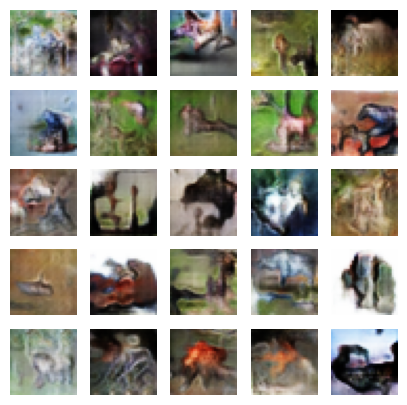

Epoch 191/250: 100%|██████████| 391/391 [00:11<00:00, 32.76batch/s, disc_loss=1.01, gen_loss=1.53] 


Epoch 191/250 - Gen Loss: 1.5144, Disc Loss: 1.0008


Epoch 192/250: 100%|██████████| 391/391 [00:11<00:00, 32.76batch/s, disc_loss=1, gen_loss=1.52]    


Epoch 192/250 - Gen Loss: 1.5061, Disc Loss: 0.9964


Epoch 193/250: 100%|██████████| 391/391 [00:11<00:00, 32.66batch/s, disc_loss=1.02, gen_loss=1.29]


Epoch 193/250 - Gen Loss: 1.2760, Disc Loss: 1.0168


Epoch 194/250: 100%|██████████| 391/391 [00:12<00:00, 31.45batch/s, disc_loss=1.01, gen_loss=1.28]


Epoch 194/250 - Gen Loss: 1.2782, Disc Loss: 1.0068


Epoch 195/250: 100%|██████████| 391/391 [00:11<00:00, 32.72batch/s, disc_loss=1.02, gen_loss=1.28]


Epoch 195/250 - Gen Loss: 1.2738, Disc Loss: 1.0104


Epoch 196/250: 100%|██████████| 391/391 [00:11<00:00, 32.65batch/s, disc_loss=1.02, gen_loss=1.3] 


Epoch 196/250 - Gen Loss: 1.2905, Disc Loss: 1.0109


Epoch 197/250: 100%|██████████| 391/391 [00:11<00:00, 32.77batch/s, disc_loss=1.03, gen_loss=1.31]


Epoch 197/250 - Gen Loss: 1.2987, Disc Loss: 1.0199


Epoch 198/250: 100%|██████████| 391/391 [00:12<00:00, 32.32batch/s, disc_loss=1.02, gen_loss=1.38] 


Epoch 198/250 - Gen Loss: 1.3761, Disc Loss: 1.0199


Epoch 199/250: 100%|██████████| 391/391 [00:11<00:00, 32.69batch/s, disc_loss=1.02, gen_loss=1.3] 


Epoch 199/250 - Gen Loss: 1.3006, Disc Loss: 1.0218


Epoch 200/250: 100%|██████████| 391/391 [00:11<00:00, 32.68batch/s, disc_loss=1.02, gen_loss=1.27]


Epoch 200/250 - Gen Loss: 1.2705, Disc Loss: 1.0188


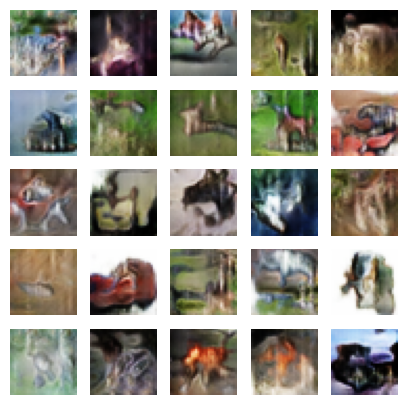

Epoch 201/250: 100%|██████████| 391/391 [00:11<00:00, 32.76batch/s, disc_loss=1.04, gen_loss=1.27]


Epoch 201/250 - Gen Loss: 1.2618, Disc Loss: 1.0290


Epoch 202/250: 100%|██████████| 391/391 [00:11<00:00, 32.66batch/s, disc_loss=1.02, gen_loss=1.36]


Epoch 202/250 - Gen Loss: 1.3628, Disc Loss: 1.0196


Epoch 203/250: 100%|██████████| 391/391 [00:11<00:00, 32.69batch/s, disc_loss=1.02, gen_loss=1.46] 


Epoch 203/250 - Gen Loss: 1.4606, Disc Loss: 1.0184


Epoch 204/250: 100%|██████████| 391/391 [00:11<00:00, 32.75batch/s, disc_loss=1.04, gen_loss=1.31]


Epoch 204/250 - Gen Loss: 1.3087, Disc Loss: 1.0431


Epoch 205/250: 100%|██████████| 391/391 [00:11<00:00, 32.72batch/s, disc_loss=1.03, gen_loss=1.23]


Epoch 205/250 - Gen Loss: 1.2334, Disc Loss: 1.0311


Epoch 206/250: 100%|██████████| 391/391 [00:11<00:00, 32.72batch/s, disc_loss=1.04, gen_loss=1.3] 


Epoch 206/250 - Gen Loss: 1.2947, Disc Loss: 1.0348


Epoch 207/250: 100%|██████████| 391/391 [00:11<00:00, 32.72batch/s, disc_loss=1.03, gen_loss=1.23]


Epoch 207/250 - Gen Loss: 1.2343, Disc Loss: 1.0346


Epoch 208/250: 100%|██████████| 391/391 [00:11<00:00, 32.69batch/s, disc_loss=1.04, gen_loss=1.22]


Epoch 208/250 - Gen Loss: 1.2217, Disc Loss: 1.0353


Epoch 209/250: 100%|██████████| 391/391 [00:11<00:00, 32.69batch/s, disc_loss=1.04, gen_loss=1.22]


Epoch 209/250 - Gen Loss: 1.2242, Disc Loss: 1.0366


Epoch 210/250: 100%|██████████| 391/391 [00:11<00:00, 32.71batch/s, disc_loss=1.04, gen_loss=1.28]


Epoch 210/250 - Gen Loss: 1.2816, Disc Loss: 1.0409


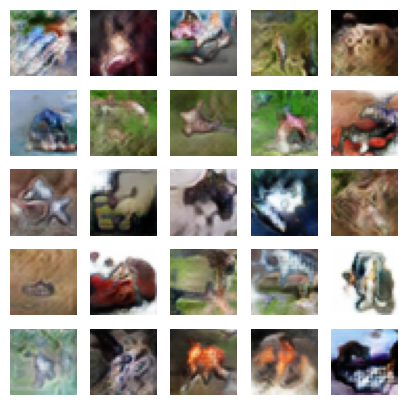

Epoch 211/250: 100%|██████████| 391/391 [00:11<00:00, 32.71batch/s, disc_loss=1.05, gen_loss=1.3] 


Epoch 211/250 - Gen Loss: 1.2878, Disc Loss: 1.0444


Epoch 212/250: 100%|██████████| 391/391 [00:14<00:00, 26.53batch/s, disc_loss=1.05, gen_loss=1.21]


Epoch 212/250 - Gen Loss: 1.2071, Disc Loss: 1.0509


Epoch 213/250: 100%|██████████| 391/391 [00:14<00:00, 26.68batch/s, disc_loss=1.05, gen_loss=1.23]


Epoch 213/250 - Gen Loss: 1.2282, Disc Loss: 1.0470


Epoch 214/250: 100%|██████████| 391/391 [00:13<00:00, 29.92batch/s, disc_loss=1.04, gen_loss=1.24]


Epoch 214/250 - Gen Loss: 1.2337, Disc Loss: 1.0417


Epoch 215/250: 100%|██████████| 391/391 [00:13<00:00, 29.89batch/s, disc_loss=1.05, gen_loss=1.31]


Epoch 215/250 - Gen Loss: 1.3100, Disc Loss: 1.0429


Epoch 216/250: 100%|██████████| 391/391 [00:13<00:00, 29.81batch/s, disc_loss=1.07, gen_loss=1.22]


Epoch 216/250 - Gen Loss: 1.2132, Disc Loss: 1.0569


Epoch 217/250: 100%|██████████| 391/391 [00:13<00:00, 29.78batch/s, disc_loss=1.06, gen_loss=1.2] 


Epoch 217/250 - Gen Loss: 1.2015, Disc Loss: 1.0557


Epoch 218/250: 100%|██████████| 391/391 [00:13<00:00, 28.23batch/s, disc_loss=1.05, gen_loss=1.24]


Epoch 218/250 - Gen Loss: 1.2415, Disc Loss: 1.0488


Epoch 219/250: 100%|██████████| 391/391 [00:13<00:00, 29.42batch/s, disc_loss=1.07, gen_loss=1.21]


Epoch 219/250 - Gen Loss: 1.1992, Disc Loss: 1.0667


Epoch 220/250: 100%|██████████| 391/391 [00:13<00:00, 29.71batch/s, disc_loss=1.06, gen_loss=1.2] 


Epoch 220/250 - Gen Loss: 1.1932, Disc Loss: 1.0567


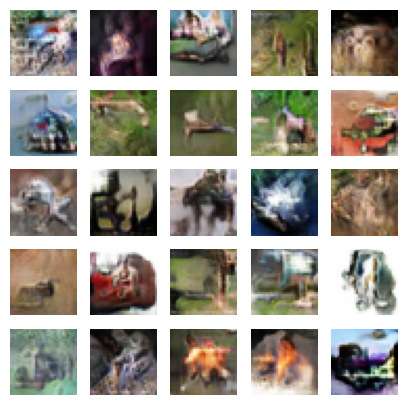

Epoch 221/250: 100%|██████████| 391/391 [00:12<00:00, 30.22batch/s, disc_loss=1.07, gen_loss=1.23]


Epoch 221/250 - Gen Loss: 1.2177, Disc Loss: 1.0571


Epoch 222/250: 100%|██████████| 391/391 [00:12<00:00, 30.16batch/s, disc_loss=1.07, gen_loss=1.28]


Epoch 222/250 - Gen Loss: 1.2813, Disc Loss: 1.0643


Epoch 223/250: 100%|██████████| 391/391 [00:12<00:00, 30.26batch/s, disc_loss=1.05, gen_loss=1.33] 


Epoch 223/250 - Gen Loss: 1.3253, Disc Loss: 1.0518


Epoch 224/250: 100%|██████████| 391/391 [00:13<00:00, 29.99batch/s, disc_loss=1.07, gen_loss=1.21]


Epoch 224/250 - Gen Loss: 1.2046, Disc Loss: 1.0636


Epoch 225/250: 100%|██████████| 391/391 [00:12<00:00, 30.35batch/s, disc_loss=1.07, gen_loss=1.19]


Epoch 225/250 - Gen Loss: 1.1871, Disc Loss: 1.0690


Epoch 226/250: 100%|██████████| 391/391 [00:12<00:00, 30.10batch/s, disc_loss=1.07, gen_loss=1.19]


Epoch 226/250 - Gen Loss: 1.1879, Disc Loss: 1.0672


Epoch 227/250: 100%|██████████| 391/391 [00:12<00:00, 31.24batch/s, disc_loss=1.06, gen_loss=1.2] 


Epoch 227/250 - Gen Loss: 1.2008, Disc Loss: 1.0623


Epoch 228/250: 100%|██████████| 391/391 [00:12<00:00, 31.30batch/s, disc_loss=1.07, gen_loss=1.18]


Epoch 228/250 - Gen Loss: 1.1767, Disc Loss: 1.0731


Epoch 229/250: 100%|██████████| 391/391 [00:13<00:00, 28.88batch/s, disc_loss=1.06, gen_loss=1.2] 


Epoch 229/250 - Gen Loss: 1.1967, Disc Loss: 1.0535


Epoch 230/250: 100%|██████████| 391/391 [00:12<00:00, 31.66batch/s, disc_loss=1.07, gen_loss=1.2] 


Epoch 230/250 - Gen Loss: 1.1895, Disc Loss: 1.0665


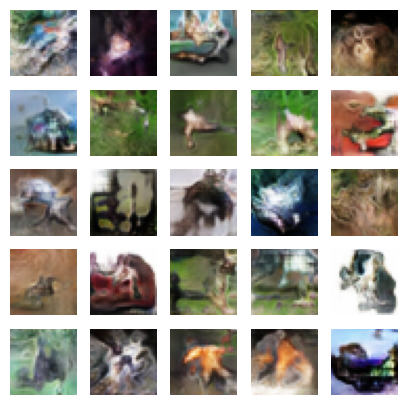

Epoch 231/250: 100%|██████████| 391/391 [00:13<00:00, 30.00batch/s, disc_loss=1.06, gen_loss=1.21]


Epoch 231/250 - Gen Loss: 1.2148, Disc Loss: 1.0634


Epoch 232/250: 100%|██████████| 391/391 [00:12<00:00, 30.67batch/s, disc_loss=1.07, gen_loss=1.21]


Epoch 232/250 - Gen Loss: 1.2046, Disc Loss: 1.0594


Epoch 233/250: 100%|██████████| 391/391 [00:11<00:00, 32.62batch/s, disc_loss=1.07, gen_loss=1.29]


Epoch 233/250 - Gen Loss: 1.2827, Disc Loss: 1.0644


Epoch 234/250: 100%|██████████| 391/391 [00:12<00:00, 32.09batch/s, disc_loss=1.06, gen_loss=1.21]


Epoch 234/250 - Gen Loss: 1.2051, Disc Loss: 1.0635


Epoch 235/250: 100%|██████████| 391/391 [00:13<00:00, 28.46batch/s, disc_loss=1.07, gen_loss=1.19]


Epoch 235/250 - Gen Loss: 1.1852, Disc Loss: 1.0659


Epoch 236/250: 100%|██████████| 391/391 [00:15<00:00, 25.47batch/s, disc_loss=1.06, gen_loss=1.19]


Epoch 236/250 - Gen Loss: 1.1897, Disc Loss: 1.0587


Epoch 237/250: 100%|██████████| 391/391 [00:12<00:00, 30.56batch/s, disc_loss=1.06, gen_loss=1.19]


Epoch 237/250 - Gen Loss: 1.1940, Disc Loss: 1.0610


Epoch 238/250: 100%|██████████| 391/391 [00:13<00:00, 29.74batch/s, disc_loss=1.07, gen_loss=1.32]


Epoch 238/250 - Gen Loss: 1.3166, Disc Loss: 1.0725


Epoch 239/250: 100%|██████████| 391/391 [00:13<00:00, 28.75batch/s, disc_loss=1.07, gen_loss=1.2] 


Epoch 239/250 - Gen Loss: 1.1976, Disc Loss: 1.0689


Epoch 240/250: 100%|██████████| 391/391 [00:12<00:00, 30.99batch/s, disc_loss=1.07, gen_loss=1.18]


Epoch 240/250 - Gen Loss: 1.1769, Disc Loss: 1.0702


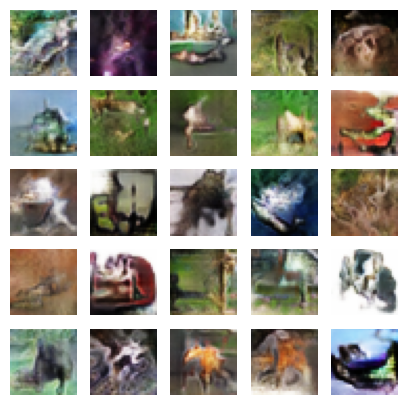

Epoch 241/250: 100%|██████████| 391/391 [00:13<00:00, 28.87batch/s, disc_loss=1.08, gen_loss=1.18]


Epoch 241/250 - Gen Loss: 1.1740, Disc Loss: 1.0753


Epoch 242/250: 100%|██████████| 391/391 [00:13<00:00, 28.66batch/s, disc_loss=1.06, gen_loss=1.19]


Epoch 242/250 - Gen Loss: 1.1855, Disc Loss: 1.0590


Epoch 243/250: 100%|██████████| 391/391 [00:12<00:00, 30.67batch/s, disc_loss=1.07, gen_loss=1.2] 


Epoch 243/250 - Gen Loss: 1.1973, Disc Loss: 1.0689


Epoch 244/250: 100%|██████████| 391/391 [00:12<00:00, 30.91batch/s, disc_loss=1.08, gen_loss=1.22]


Epoch 244/250 - Gen Loss: 1.2127, Disc Loss: 1.0698


Epoch 245/250: 100%|██████████| 391/391 [00:13<00:00, 29.97batch/s, disc_loss=1.07, gen_loss=1.2] 


Epoch 245/250 - Gen Loss: 1.1951, Disc Loss: 1.0672


Epoch 246/250: 100%|██████████| 391/391 [00:13<00:00, 29.74batch/s, disc_loss=1.07, gen_loss=1.19]


Epoch 246/250 - Gen Loss: 1.1882, Disc Loss: 1.0651


Epoch 247/250: 100%|██████████| 391/391 [00:12<00:00, 31.54batch/s, disc_loss=1.06, gen_loss=1.21]


Epoch 247/250 - Gen Loss: 1.2056, Disc Loss: 1.0613


Epoch 248/250: 100%|██████████| 391/391 [00:12<00:00, 30.83batch/s, disc_loss=1.09, gen_loss=1.5] 


Epoch 248/250 - Gen Loss: 1.4978, Disc Loss: 1.0833


Epoch 249/250: 100%|██████████| 391/391 [00:12<00:00, 30.32batch/s, disc_loss=1.07, gen_loss=1.22]


Epoch 249/250 - Gen Loss: 1.2186, Disc Loss: 1.0676


Epoch 250/250: 100%|██████████| 391/391 [00:13<00:00, 28.20batch/s, disc_loss=1.07, gen_loss=1.18]


Epoch 250/250 - Gen Loss: 1.1725, Disc Loss: 1.0684


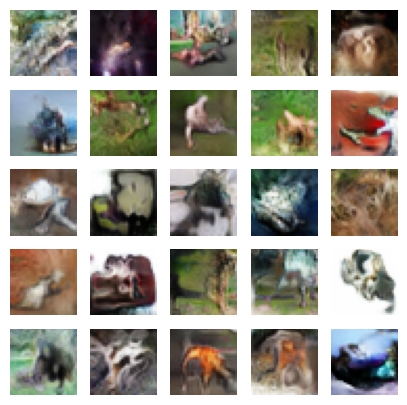

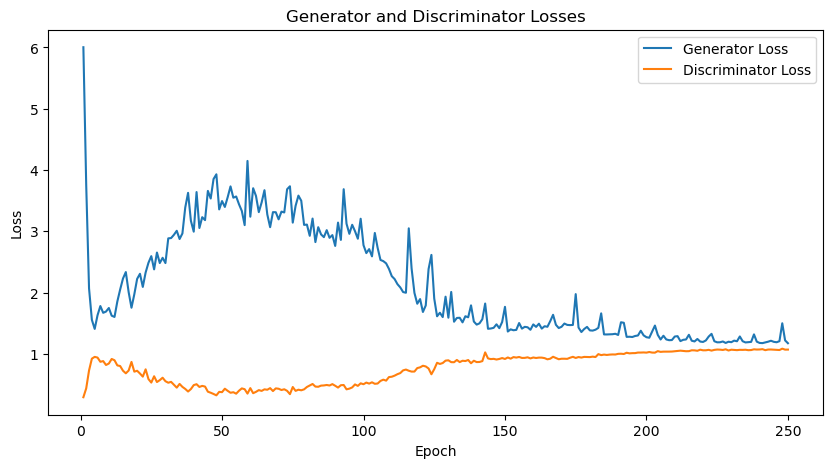

In [11]:
# Run the training
train(train_dataset, epochs=250)